In [18]:
# IMPORTS
from __future__ import division
import numpy as np
import scipy.stats as stats
import seaborn as sns
import math
from numpy import random as npr
from matplotlib import pyplot as plt
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
import warnings
import time
import pandas as pd
from sklearn import linear_model as lm

%matplotlib inline
np.set_printoptions(precision=5)
npr.seed(1)

warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', np.VisibleDeprecationWarning)

# Centrer et réduire les données:
def centrer_reduire(x):
    if type(x) == pd.Series:
        return StandardScaler().fit_transform(x)
    if type(x) == pd.DataFrame:
        x_copy = pd.DataFrame()
        for col in x.columns:
            x_copy[col] = StandardScaler().fit_transform(x[col])
        return x_copy
    raise TypeError('type not supported: ' + str(type(x)))

## Exercice 1

### 1) Generate n=500 samples from a Beta distribution with parameter (α,β)=(2,5). Display the histogram of this sample with 25 bins.

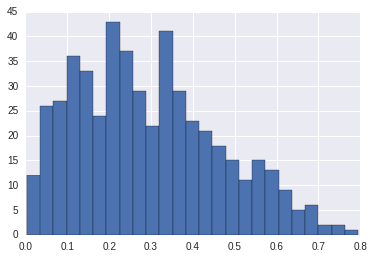

In [3]:
(a, b) = (2, 5)
n1 = 500

samples = npr.beta(a, b, n1)
plt.hist(samples, bins=25, label='Samples from Beta distribution')
plt.show()

### 2) Generate n=500 independent random vectors (Xi1, Xi2) dans R² where each coordinate is independent of the other and both having a Beta distribution with parameter (α,β)=(2,5). Compute the mean vector µˆ(in R²). In the next we apply some bootstrap techniques to estimate the variance and the bias of µˆ.


In [4]:
# Stick 2 beta distributions together
X = list(zip(npr.beta(a, b, n1), npr.beta(a, b, n1)))
print("X[:10] = ", "\n\t  ".join("({x_i1:.4}, {x_i2:.4})".format(x_i1=x_i1, x_i2=x_i2) for x_i1, x_i2 in X[:10]))

mu_chap = np.mean(X, axis=0)
print("mu_chap = ", mu_chap)

X[:10] =  (0.1017, 0.2402)
	  (0.3817, 0.1455)
	  (0.1452, 0.2323)
	  (0.1126, 0.05184)
	  (0.4579, 0.3351)
	  (0.2953, 0.1904)
	  (0.3499, 0.1302)
	  (0.235, 0.2451)
	  (0.1954, 0.4197)
	  (0.2179, 0.09383)
mu_chap =  [ 0.28147  0.28842]


### 3) Compute B=500 bootstrap estimators of the mean µ_chap_star_1, ..., µ_chap_star_B (µ_chap_star_b in R²). On the same plot, represent the observed data, the estimated mean µ_char and the 500 bootstrap estimators of the mean µ_chap_star_b. Note that since µ_chap is in R², the variance is a (2x2) matrix

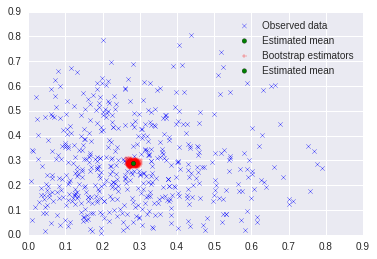

In [5]:
B = 500

# Bootstrap estimators of the mean
mu_chap_stars = [np.mean([X[i] for i in npr.randint(0, n1, n1)], axis=0) for _ in range(B)]

# For an array of tuples, retrieve the i-th item of each pair as a list
def a_i(a,i):
    return [m[i] for m in a]

# Initialize plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the observed data
ax.scatter(a_i(X,0), a_i(X,1), c='b', marker='x', label='Observed data')

# Now, locate the estimated mean of the beta distributions
ax.scatter(mu_chap[0], mu_chap[1], c='g', marker='o', label='Estimated mean')

# Then plot the boostrap estimators of the mean
ax.scatter(a_i(mu_chap_stars,0), a_i(mu_chap_stars,1), c='r', marker='+', label='Bootstrap estimators')

# Finally, locate the estimated mean of the beta distributions
ax.scatter(mu_chap[0], mu_chap[1], c='g', marker='o', label='Estimated mean')

# There should be no negative values, so focus on the interesting part
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
plt.legend(loc='upper right')
plt.show()


### 4) Give bootstrap and jackknife estimates of the bias and the variance of the mean estimator mu_chap


In [6]:
print("Bootstrap:")
bs_bias = np.sum(mu_chap_stars - mu_chap, axis=0) / B
print('biais de l\'estimateur de la moyenne:', bs_bias)

mu_star_bar = np.mean(mu_chap_stars, axis=0)
bs_diff = np.subtract(mu_chap_stars, mu_star_bar)
bs_variance = bs_diff.T.dot(bs_diff) / B
print('covariance de l\'estimateur de la moyenne:', *bs_variance, '\n')


print("Jackknife:")
jk_samples = [X[:i] + X[i+1:] for i in range(len(X))]
jk_bias = np.sum(np.mean(jk_samples, axis=0) - mu_chap, axis=0) * (1 - 1/n1)
print('biais de l\'estimateur de la moyenne:', jk_bias)

mu_minus_i = [np.mean(jk_samples[i], axis=0) for i in range(n1)]
jk_diff = np.subtract(mu_minus_i, np.mean(mu_minus_i, axis=0))
jk_variance = jk_diff.T.dot(jk_diff) * (1 - 1/n1)
print('covariance de l\'estimateur de la moyenne:', *jk_variance, '\n')


aspt_diff1 = np.subtract(X, mu_chap)
var_n_X = aspt_diff1.T.dot(aspt_diff1) / (n1*(n1-1))
print('var(X)/n = ', *var_n_X, '\n')

Bootstrap:
biais de l'estimateur de la moyenne: [ -1.31832e-06  -3.61571e-05]
covariance de l'estimateur de la moyenne: [  5.78499e-05   1.94215e-06] [  1.94215e-06   5.26125e-05] 

Jackknife:
biais de l'estimateur de la moyenne: [  8.74491e-14   8.31002e-15]
covariance de l'estimateur de la moyenne: [  5.42022e-05   3.23499e-07] [  3.23499e-07   5.52020e-05] 

var(X)/n =  [  5.42022e-05   3.23499e-07] [  3.23499e-07   5.52020e-05] 



### 5) Give the true variance of the estimator of the mean.

In [7]:
def var_beta(a, b):
    return (a*b) / ((a+b+1) * (a+b)**2)

v_beta_2_5 = var_beta(2,5) * n1**-1
print("Variance d'une loi Beta de paramètres (a,b)=(2,5):", v_beta_2_5)
print("Cette valeur apparaît pour les termes diagonaux de la vraie variance. \
Les termes non-diagonaux sont nuls, car les distributions sont indépendantes.\n")
true_var = [[v_beta_2_5, 0], [0, v_beta_2_5]]

print("Distance bootstrap variance / true variance:")
dist_bs = np.subtract(bs_variance, true_var)
print(abs(dist_bs[0,0]) + abs(dist_bs[1,0]) + abs(dist_bs[1,1]), '\n')

print("Distance jackknife variance / true variance:")
dist_jk = np.subtract(jk_variance, true_var)
print(abs(dist_jk[0,0]) + abs(dist_jk[1,0]) + abs(dist_jk[1,1]))

Variance d'une loi Beta de paramètres (a,b)=(2,5): 5.102040816326531e-05
Cette valeur apparaît pour les termes diagonaux de la vraie variance. Les termes non-diagonaux sont nuls, car les distributions sont indépendantes.

Distance bootstrap variance / true variance:
1.03637083305e-05 

Distance jackknife variance / true variance:
7.68693758299e-06


## Exercice 2

### 6) Generate n=300 independent random vectors Xi with 2 dependent components satisfying Xi2=Xi1 + Ui where Xi1 ~ U[0,1] and Ui ~ U[-.1,.1] are independent (and U stands for uniform distribution).

In [8]:
n2 = 300

def generateX(n):
    return [(xi, xi + npr.uniform(-.1,.1)) for xi in npr.uniform(size=n)]

def t(X):
    return np.transpose(X)

X = generateX(n2)

### 7) Compute the true correlation coefficient c0 and an estimated correlation coefficient ĉ of Xi1 and Xi2.

In [9]:
c0 = 1.04**(-0.5)
print("Après calcul, la vraie corrélation vaut", c0)

def c_chap(X):
    return np.corrcoef(t(X))[1,0]

c_chapeau = c_chap(X)
print("La corrélation estimée vaut", c_chapeau)

Après calcul, la vraie corrélation vaut 0.9805806756909201
La corrélation estimée vaut 0.980327286512


### 8) Compute a 5% basic bootstrap confidence interval for the correlation coefficient, for B=500 bootstrap replicas

In [10]:
def bootstrap_corr(X, B):
    n = len(X)
    return [np.corrcoef(t([X[i] for i in npr.randint(0,n,n)]))[0,1] for _ in range(B)]

sqN = math.sqrt(len(X))
bs_corr = bootstrap_corr(X, B)
alpha = 5.0

def ic_basic_bootstrap(X, B, b_c, c_c):
    std_corr = np.subtract(b_c, c_c) * sqN
    ksi1 = np.percentile(std_corr, 100. - alpha/2)
    ksi2 = np.percentile(std_corr, alpha/2)
    return [c_c - ksi1 / sqN, c_c - ksi2 / sqN]

print(ic_basic_bootstrap(X, B, bs_corr, c_chapeau))

[0.97734799988661214, 0.98351996748768344]


### 9) Compute a 5% percentile bootstrap confidence interval for the correlation coefficient, for a number B=500 of bootstrap replicas.

In [11]:
def ic_percentile_bootstrap(X, B, b_c):
    q1 = np.percentile(b_c, alpha/2)
    q2 = np.percentile(b_c, 100 - alpha/2)
    return [q1,q2]

ic_pb = ic_percentile_bootstrap(X, B, bs_corr)
ic_pb

[0.9771346055364617, 0.983306573137533]

### 10) Compute a 5% asymptotic confidence interval for the correlation coefficient.

In [12]:
# Calculate jk_var, variance of sqrt(n)*(bs_corr - c0), using the jackknife technique
def ic_asymptotic(X, b_c, c_c):
    sqN = math.sqrt(len(X))
    std_corr = list(np.subtract(b_c, c_c) * sqN)
    jk_var = np.mean([math.sqrt(np.var(std_corr[:i] + std_corr[i+1:])) for i in range(n2)])

    ksi = 1.96
    return [c_c - jk_var * ksi / sqN, c_c + jk_var * ksi / sqN]

ic_asymp = ic_asymptotic(X, bs_corr, c_chapeau)
ic_asymp

[0.97719516311581889, 0.98345940990832625]

### 11) By means of simulation (use for instance M=2000 repetitions of the experiment with a Monte-Carlo approach), evaluate the coverage probability associated to each method: basic (in question 8), percentile (in question 9) and asymptotic-jackknife (in question 10). If I is a confidence interval that has been computed using one of the previous technique, the coverage probability associated to I is : P(c0 in I)

In [69]:
def is_in_ic_bb(X, B, bs_c, c_c):
    ic_bb = ic_basic_bootstrap(X, B, bs_c, c_c)
    return 1 if ic_bb[0] <= c0 <= ic_bb[1] else 0

def is_in_ic_pb(X, B, bs_c):
    ic_pb = ic_percentile_bootstrap(X, B, bs_c)
    return 1 if ic_pb[0] <= c0 <= ic_pb[1] else 0

def is_in_ic_a(X, bs_c, c_c):
    ic_a = ic_asymptotic(X, bs_c, c_c)
    return 1 if ic_a[0] <= c0 <= ic_a[1] else 0

def are_in_ic(n):
    X = generateX(n)
    c_c = c_chap(X)
    b_c = bootstrap_corr(X,B)
    return [is_in_ic_bb(X, B, b_c, c_c), is_in_ic_pb(X, B, b_c), is_in_ic_a(X, b_c, c_c)]

def estimate_coverage(n, M):
    start = time.time()
    
    with Pool() as pool:
        res = np.sum(pool.map(are_in_ic, (n,)*M), axis=0)
    
    print(res)
    res = np.multiply(res, 100 / M)
    print("Ellapsed time:", int(time.time() - start), 's')    
    print("Coverage probability for basic bootstrap:", res[0], '%')
    print("Coverage probability for percentile bootstrap:", res[1], '%')
    print("Coverage probability for asymptotic:", res[2], '%\n')

    return res

    
M = 500
estimate_coverage(n2, M)

[458 458 465]
Ellapsed time: 36 s
Coverage probability for basic bootstrap: 91.6 %
Coverage probability for percentile bootstrap: 91.6 %
Coverage probability for asymptotic: 93.0 %



array([ 91.6,  91.6,  93. ])

### 12) Draw the evaluated coverage probabilities for different sample sizes n=30, 50, 100, 300.

In [13]:
res30 = estimate_coverage(30, M)
res50 = estimate_coverage(50, M)
res100 = estimate_coverage(100, M)
res300 = estimate_coverage(300, M)

Ellapsed time: 43 s
Ellapsed time: 39 s
Ellapsed time: 41 s
Ellapsed time: 75 s


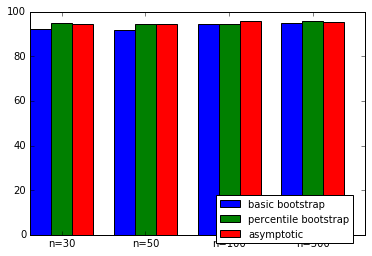

In [14]:
res = [*res30, 0, *res50, 0, *res100, 0, *res300]

fig, ax = plt.subplots()

width = 1
blue = [0,4,8,12]
ax.bar(blue, [res[i] for i in blue], 1, color='blue', label='basic bootstrap')
green = [1,5,9,13]
ax.bar(green, [res[i] for i in green], 1, color='green', label='percentile bootstrap')
red = [2,6,10,14]
ax.bar(red, [res[i] for i in red], 1, color='red', label='asymptotic')

ax.set_xticks([1.5, 5.5, 9.5, 13.5])
ax.set_xticklabels(['n=30','n=50','n=100','n=300'])
ax.set_ylim(ymax=100)
plt.legend(bbox_to_anchor=(.98, 0.2), prop={'size':10})

plt.show()

## Exercice 3

### 13) Compute the least-square estimator (θ̂0 , θ̂) of (θ0 , θ). Compute the estimated residuals vector and draw its density.

    cylinders  displacement  horsepower  weight  acceleration  year
0         8.0         307.0       130.0  3504.0          12.0  70.0
1         8.0         350.0       165.0  3693.0          11.5  70.0
2         8.0         318.0       150.0  3436.0          11.0  70.0
3         8.0         304.0       150.0  3433.0          12.0  70.0
4         8.0         302.0       140.0  3449.0          10.5  70.0
5         8.0         429.0       198.0  4341.0          10.0  70.0
6         8.0         454.0       220.0  4354.0           9.0  70.0
7         8.0         440.0       215.0  4312.0           8.5  70.0
8         8.0         455.0       225.0  4425.0          10.0  70.0
9         8.0         390.0       190.0  3850.0           8.5  70.0
10        8.0         383.0       170.0  3563.0          10.0  70.0
11        8.0         340.0       160.0  3609.0           8.0  70.0
12        8.0         400.0       150.0  3761.0           9.5  70.0
13        8.0         455.0       225.0  3086.0 

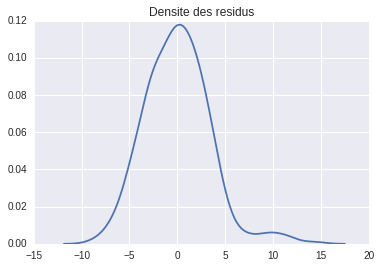

In [106]:
names = [
    'mpg',
    'cylinders',
    'displacement',
    'horsepower',
    'weight',
    'acceleration',
    'year',
    'origin',
    'car name'
]

url = "auto-mpg.data-original"
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
df = pd.read_csv(url, sep=r"\s+", names=names)

df = df.dropna(axis=0)
df.reset_index(inplace=True)

y = df['mpg']
x = df[names[1:-2]]
print(x.head(15))

n3 = len(x)

clf1 = lm.LinearRegression()
clf1.fit(x, y)
theta = [clf1.intercept_]
theta.extend(clf1.coef_)

y_chap = clf1.predict(x)
residuals = y - y_chap
theta1 = theta[1]

print('theta_chap =', theta)

sns.kdeplot(residuals)
plt.title('Densite des residus')
plt.legend([], [])
plt.show()

### 14) Give a 5% confidence interval for the coefficient θ1 , associated to the variable cylinders, based on the hypothesis that each εi is Gaussian.

In [107]:
rgX = np.linalg.matrix_rank(x)

# 5-quantile de la loi de Student
q5 = stats.t.ppf(1-0.05/2, n3-rgX)
print('q5 =', q5)

sqrt_tXX_inv = math.sqrt(np.linalg.inv(np.dot(x.T, x))[0,0])
print('sqrt_tXX_inv =', sqrt_tXX_inv)

norm_res_sq = np.linalg.norm(residuals)**2
print('norm_res_sq =', norm_res_sq)

sigma_chap = math.sqrt(norm_res_sq / (n3 - rgX))
print('sigma_chap =', sigma_chap)

width = q5 * sigma_chap * sqrt_tXX_inv
ic_theta1 = [theta1 - width, theta1 + width]
ic_theta1

q5 = 1.96612875289
sqrt_tXX_inv = 0.09491039069014502
norm_res_sq = 4543.34702471
sigma_chap = 3.4307913197354245


[-0.97006549905144801, 0.31034732090353356]

### 15) Implement the bootstrap method based on the residuals (this method is specified in the beamer of the class, here ĝ(Xi) = θ̂0 + transose(Xi).θ̂). On the same graph, draw the response yi and the bootstrap responses yi* versus the estimated response Xi.transpose(θ̂)

In [132]:
B = 500
yis = [y_chap + residuals[npr.randint(0,n3,n3)] for _ in range(B)]

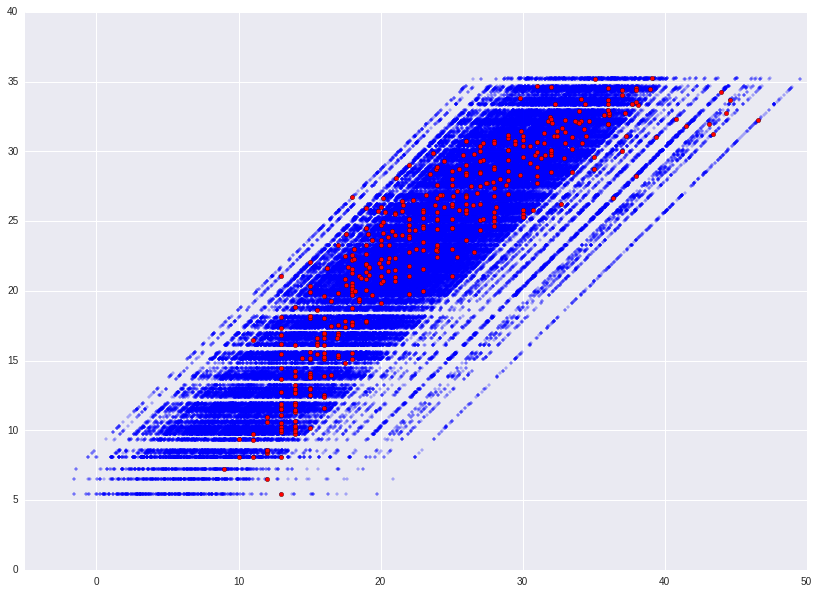

In [142]:
# Initialize plot
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

for yi in yis:
    ax.scatter(yi, y_chap, c='b', marker='+')

ax.scatter(y, y_chap, c='r', marker='o', label='Bootstrap estimators')

ax.set_xlim(-5, 50)
plt.legend([], [])
plt.show()

### 16) Compute a basic bootstrap confidence interval for θ1

In [134]:
def calc_theta1(x, yi):
    clf_b = lm.LinearRegression()
    clf_b.fit(x, yi)
    return clf_b.coef_[0]

sqN3 = math.sqrt(n3)
bs_diff = list(map(lambda yi: sqN3*(calc_theta1(x, yi) - theta1), yis))
ksi1 = np.percentile(bs_diff, 100. - 5/2)
ksi2 = np.percentile(bs_diff, 5/2)
ic_bs = [theta1 - ksi1 / sqN3, theta1 - ksi2 / sqN3]
ic_bs

[-1.0473153970088469, 0.27962242119319458]

### 17) For each method, create a figure representing the confidence intervals of every coefficient θ1,...,θ6 (except the intercept θ0) and the estimators θ̂1,...,θ̂6. The x-axis should be reserved for the indexes j=1,...,6. We shall notice that many confidence intervals contains the value 0 meaning that some are not significant.